# Iterated Prisoner's Dilemma

## The problem
The Prisoner's dilemma is an example of a game that shows why two rational individuals might not cooperate, even if it appears in their best interest to do so.  
The most common example cites as follows:  
"Two members of a criminal gang are arrested and imprisoned. Each prisoner is in solitary confinement with no means of speaking to or exchanging messages with the other. The police admit they don't have enough evidence to convict the pair on the principal charge. They plan to sentence both to a year in prison on a lesser charge. Simultaneously, the police offer each prisoner a Faustian bargain." ([cit](https://www.worldcat.org/title/prisoners-dilemma/oclc/23383657))

Each player A and B has two actions: cooperate (C) with the other prisoner or defect (D), giving them up to the autorities. Both players decide on their action without knowing the action of the other player.

In the following matrix, the values $(A_{i,j},B_{i,j})$ refer to the payoff A and B, respectively, would get in the case A chose action $i$ and B chose action $j$, where $i,j \in \{ \text{cooperate}, \text{defect}\}$. 

$$
\begin{aligned}
& \text {Payoff matrix }\\
&\begin{array}{cccc}
\hline \hline  &  & \qquad \text{Prisoner B} \\
 &  & \text{Cooperate}  & \text{Defect} \\
\text{Prisoner A} & \text{Cooperate} & (R,R) & (S,T) \\
 & \text{Defect} & (T,S) & (P,P) \\
\hline
\end{array}
\end{aligned}
$$
This table defines a Prisoner’s Dilemma game if $T > R > P > S$ and $2R > S + T$. This way, the dilemma unfolds: As the aim is for the highest payoff possible, for each player it is individually beneficial to defect, irrespective of the choice of his opponent. The highest mutual payoff, however, is generated when both players cooperate.

It is assumed that both prisoners understand the nature of the game, have no loyalty to each other, and will have no opportunity for retribution or reward outside the game. 

### Iterated version
If two players play the game more than once in succession, they remember previous actions of their opponent and change their strategy accordingly, the game is called Iterated Prisoner's Dilemma (IPD).  
After each game, each player observes both the previous action of their opponent and their own previous action.

## Formalisation
The prisoner's dilemma is a 2-player Matrix game, with only four states and two choices of actions. Since the reward (payoff) for a given action depends also on the actions of the other player, it is an adversarial bandits problem.  
The four states consist of all possible combinations of actions for (A's previous action, B's previous action): $(C,C), (C,D), (D,C), (D,D)$. However, this setting can be simplified in some cases presented later.

At each time $t$, the players simultaneously choose their actions. The rewards depend on both actions, and they can be written as the payoff matrix reported above.  

Considering the set of possible actions, if for any pair no individual player can benefit by changing its individual strategy, then that's a Nash equilibrium. In this case, as mentioned earlier, the Nash equilibrium is defecting. 


### Q-Learning 
Our player (agent) learns the value function via Q-learning, a reinforcement learning technique developed in $1989$ that iteratively updates expected cumulative discounted rewards $Q$ given a state $s$ and an action $a$ (from [Sutton and Barto](http://incompleteideas.net/book/RLbook2018.pdf)):  
<img src="Qlearning.png" width="500">


The action gets chosen using an $\varepsilon$-greedy policy, that is, 
$$A_t = \begin{cases} \max_a Q(s,a) \quad \text{with probability } 1- \varepsilon \\ \text{random action} \quad \text{with probability }\varepsilon \end{cases}$$

As the update rule does not depend on the current exploration but on the assumed optimal choice, Q-Learning does not require the current policy to converge towards the optimal policy, therefore doesn't need a decaying $\varepsilon$. Q-learning is able to generate an optimal policy even using only uniformly random actions, given sufficient iterations. However, the decay can be set as a parameter when instantiating the player, and can be of help in some situations.

The parameters used are:
* The values $R = 3$, $S = 0$, $T =5$, $P=1$ for the payoff matrix
* a discount factor $\gamma = 0.95$
* a decaying learning rate $\alpha_t = \frac{1}{t+1}$
* an epsilon $\varepsilon = 0.2$. If a decay is set, the reachable minimum is set to $\varepsilon = 0.1$

To better visualise it, the payoff matrix is
$$
\begin{aligned}
& \text {Payoff matrix }\\
&\begin{array}{cccc}
\hline \hline  &  & \qquad \text{Prisoner B} \\
 &  & \text{Cooperate}  & \text{Defect} \\
\text{Prisoner A} & \text{Cooperate} & (3,3) & (0,5) \\
 & \text{Defect} & (5,0) & (1,1) \\
\hline
\end{array}
\end{aligned}
$$

### Opponent's deterministic strategies
Over time various deterministic strategies in the IPD game emerged. The ones that will be considered here are:
* *Always cooperate*: always cooperate, indepentently of period or observed actions. If played against itself, it always receives a reward of 3 in this setting.
* *Always defect*:  This strategy is by definition unexploitable and will always have at least the same average reward as the opposing strategy.
* *Random action*: As the name implies, this strategy plays a random action independent of period and observations. The probability to play a cooperation is set to $0.5$.
* *Tit-for-tat*: This strategy starts with a cooperation and copies the move of the opponent in the following periods.

The state space can also be analysed from the opponent's point of view:  
In the first three cases, the space could be simplified to a single default state, as these strategies do not react to their observations and are therefore always in the same situation.  
For Tit-for-tat, two states would be sufficient, and they depend on whether a defection has been observed in the previous period or not.  

## Goal
The questions this project tries to answer are: can a Q-Learning agent learn to play:
* vs a deterministic strategy?
* vs another Q-Learning agent?

## Implementation

First, import all needed classes and functions.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from utils import Game, Meeting
from strategy import Cooperate, Defect, Random, TitforTat, QLearning

Let's define the payoff matrix, and the possible actions. We can instantiate a first game with them, and get the Nash equilibrium.

In [2]:
# define payoff matrix
payoff =[[(3,3),(0,5)],[(5,0),(1,1)]]

# initiate game with two possible actions: cooperate or defect
# numeric action codes: [0,1]
actions = [0,1] 
g = Game(payoff, actions)

# returns a list of Nash equilibrium indexes
g.getNash() 

[(1, 1)]

As expected, the Nash equilibrium is to defect.

Let's see how the strategies play out. Remember that 0 = Cooperate, 1 = Defect.

In [3]:
# test action classes
for strategy in [Cooperate(), Defect(), Random()]: 
    s1 = strategy
    print(s1.name,end=" ")
    for i in range (0,20):
        print(s1.get_action(i), end=' ')
    print('\n')

cooperate 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

defect 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

random 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 



To test Tit-for-Tat, we need an opponent, so we create a meeting. The player starts by cooperating, to then copy the opponent's previous action.  
```pretty_print()``` reports the first (max 50) actions for each player and their scores. The score is the sum of the scores obtained on each game, according to the payoff matrix. The higher the better.

In [4]:
m = Meeting(g, TitforTat(), Random(), 20)
m.run()
m.pretty_print()

TitforTat	0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 ... 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 = 47
random	0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 ... 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 = 47


We can also display the counter for how many times each player decided to cooperate.

In [5]:
s1 = TitforTat()
s2 = Defect()
m = Meeting(g, s1, s2, 100)
m.run()
m.pretty_print()

print()
print("Number of cooperations : " )
print (m.s1.name + "\t" + str(m.num_cooperation_s1))
print (m.s2.name + "\t" + str(m.num_cooperation_s2))

TitforTat	0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 = 99
defect	1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 = 104

Number of cooperations : 
TitforTat	1
defect	0


### All vs all

Let's play every strategy against every opponent, counting the average reward per game of Player A against Player B.  
Again, each time the cell is ran the results can vary due to randomness, although the decision to run the same meeting multiple times to infer the results was made to reduce the effect.

For the Q-learner, a few different combinations of parameters are tried.

In [6]:
payoff =[[(3,3),(0,5)],[(5,0),(1,1)]]
actions = [0,1] 
g = Game(payoff, actions)

strategies = [Cooperate(), Defect(), Random(), TitforTat(), QLearning(epsilon = 0.2), QLearning(epsilon = 0.5), QLearning(epsilon=0.5, decay = 0.999)]
avg_reward_table = []
wins_table = []
coops_table = []
runs = 100
games = 20000

for player1 in strategies:
    avg_reward = []
    wins_percent = []
    coops_percent = [] 
    for player2 in strategies:
        tot_reward = 0
        tot_wins = 0
        coops = []
        for i in range(runs):
            s1 = player1
            s2 = player2
            m = Meeting(g, s1, s2, games)
            m.run()
            tot_reward += m.s1_score
            if m.s1_score > m.s2_score:
                tot_wins += 1
            coops.append(m.num_cooperation_s1 /games)
        avg_reward.append(tot_reward/(runs*games))
        wins_percent.append(tot_wins/runs)
        coops_percent.append(np.mean(coops))
    avg_reward_table.append(avg_reward)
    wins_table.append(wins_percent)
    coops_table.append(coops_percent)

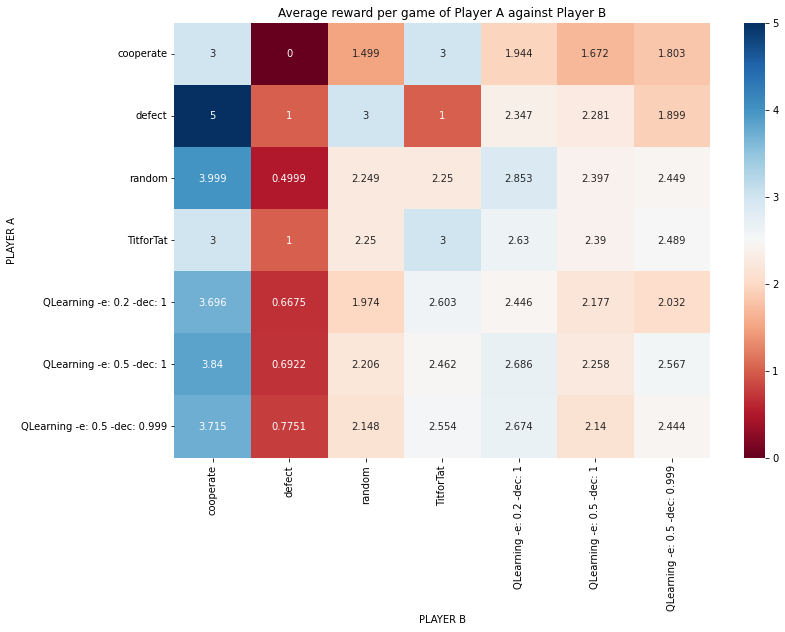

In [7]:
df = pd.DataFrame(avg_reward_table, index = [s.name for s in strategies], columns = [s.name for s in strategies])

plt.figure(figsize = (12,8))
s = sn.heatmap(df, annot=True, cmap = 'RdBu', fmt = '.4g')
s.set(xlabel='PLAYER B', ylabel='PLAYER A', title=f'Average reward per game of Player A against Player B');

Each player's goal is to maximise their own reward.  
As we can see from the table, always cooperating is the worst strategy, as it leads to the worst average results in most cases and, even in its best cases, the rewards are  only slightly above average.

Like the Nash equilibrium suggested, the best bet is to always defect. That way, whichever action Player B chooses, Player A's payoff will always be the highest possible. In addition, there is a possibility to obtain the highest payoff possible, which other strategies don't have.  

Let's look at the Q-learners' results. They all perform fairly similarly in most cases against deterministic strategies. When facing a defecting agent and Tit-for-Tat a lower exploration is slightly preferred, as it leads to a higher average reward. This is probably due to a higher percentage of defecting actions chosen from the Q-table, indicating that the Q-learner converges to the Nash equilibrium.   
As expected from theory, a decay in Q-learning is not strictly necessary, but can help in certain situations.

To help answer the original questions, let's see the average percentage of cooperations. Perhaps, the agent could converge towards the cooperating route!

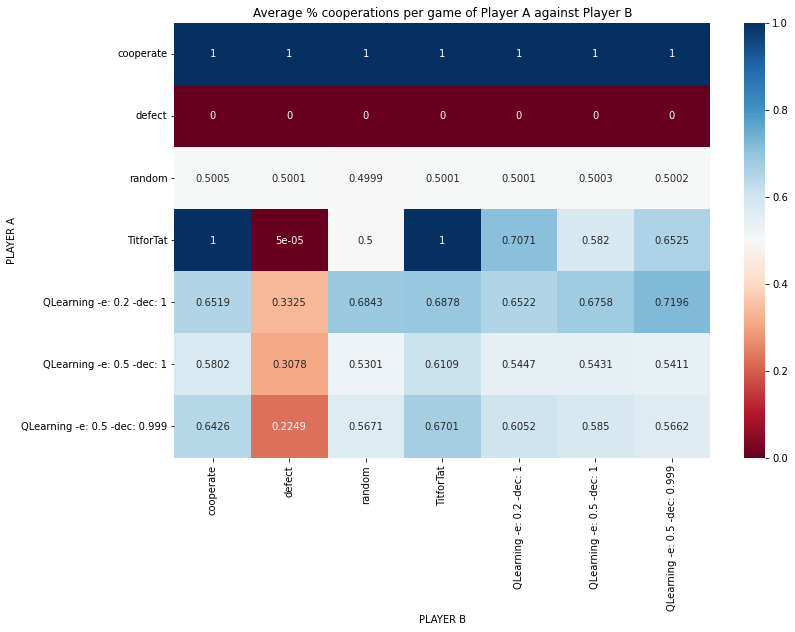

In [8]:
df = pd.DataFrame(coops_table, index = [s.name for s in strategies], columns = [s.name for s in strategies])

plt.figure(figsize = (12,8))
s = sn.heatmap(df, annot=True, cmap = 'RdBu', fmt = '.4g')
s.set(xlabel='PLAYER B', ylabel='PLAYER A', title=f'Average % cooperations per game of Player A against Player B');

The Q-learning agent can be seen learning to cooperate against a cooperating agent, and defecting against a defecting one. While the first behaviour is egoistically sub-optimal, the second can be considered a big success from that point of view.  
In all the Q-learning rows, we can see a higher quantity of cooperations instead of defections, especially with less exploration. From this what can be deduced is that the Q learner is not a very good player of the game, failing to learn that defecting is the way to go for a higher reward.

Lastly, let's see the percentage of wins. This is not helpful to the original question, but can still be interesting to see.

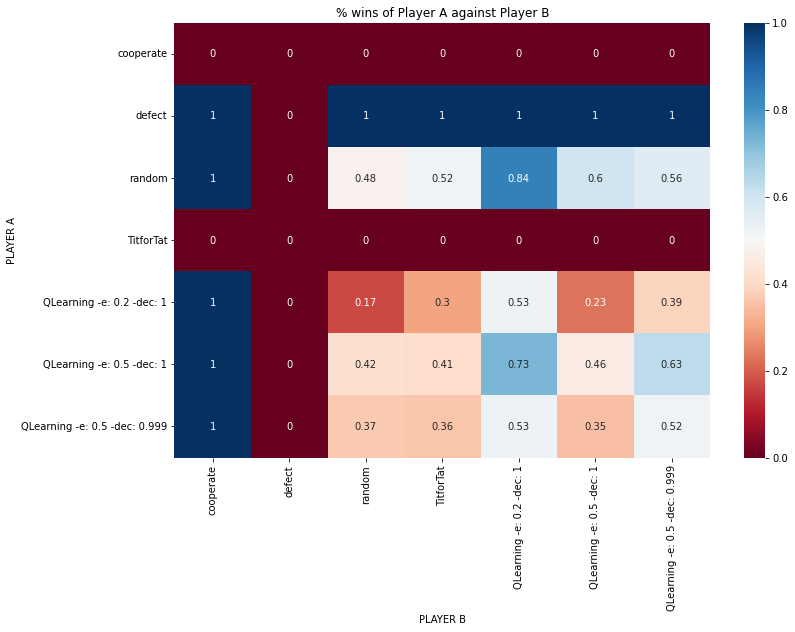

In [9]:
df = pd.DataFrame(wins_table, index = [s.name for s in strategies], columns = [s.name for s in strategies])

plt.figure(figsize = (12,8))
s = sn.heatmap(df, annot=True, cmap = 'RdBu', fmt = '.4g')
s.set(xlabel='PLAYER B', ylabel='PLAYER A', title=f'% wins of Player A against Player B');

Against all opponents a higher starting exploration percentage produce more wins. On the other hand, the introduction of decay produces less of them, confirming its redundancy in QLearning.  
This doesn't affect the performance evaluation of the players, as the aim is highest reward.

## Answers

Let's see if the Q-learning agent has learnt some strategies against the different opponents by exploring the resulting Q tables and history of actions. It's parameters will be set to the ones that got the highest average reward in the previous table.

### Can a Q-learning agent learn to play against a deterministic strategy?

In [10]:
# how to read the Q table:
# first as states:
# [[I cooperate],         in each block:  
#                         [[they cooperate],                   in each row, for action:
#  [I defect   ]]         [they defect   ]]                    [next is cooperate, next is defect]

In [11]:
s1 = QLearning(epsilon = 0.5)
s2 = Cooperate()
m = Meeting(g, s1, s2, 50000)
m.run()
m.pretty_print()

m.s1.print_qtable()

QLearning -e: 0.5 -dec: 1	0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 ... 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 = 174920
cooperate	0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 = 112620


array([[[16.18248725, 11.17485879],
        [ 0.        ,  0.        ]],

       [[12.11760903,  6.04623862],
        [ 0.        ,  0.        ]]])

The RL agent gets a heavy win, as expected.  
The Q table is updated only for instances when the opponent cooperates, as the agent has no occasions to explore the other states. The learnt strategy varies a lot depending on the random seed. From the average reward in the table above, however, we can deduce that the Q-learner tends slightly towards cooperation, as confirmed from the percentage of cooperations plotted below it.

In [12]:
s1 = QLearning(epsilon = 0.5, decay = 0.999)
s2 = Defect()
m = Meeting(g, s1, s2, 50000)
m.run()
m.pretty_print()
m.s1.print_qtable()

QLearning -e: 0.5 -dec: 0.999	1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 ... 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 = 24972
defect	1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 = 150112


array([[[0.        , 1.        ],
        [0.46202355, 2.14333812]],

       [[0.        , 0.        ],
        [1.63069338, 0.56128451]]])

The Q-learner loses to the defecting opponent, as predicted from the table above. Again, the states that include a cooperation from the opponent are not explored, for clear reasons.  
In this case, the agent only option was to learn to always defect as well, and aim for a tie. This fails to happen at the beginning where more exploration is in place, but it is successfully picked up by the RL agent soon enough to not lose too badly. 

In [13]:
s1 = QLearning(epsilon = 0.5)
s2 = Random()
m = Meeting(g, s1, s2, 50000)
m.run()
m.pretty_print()
m.s1.print_qtable()

QLearning -e: 0.5 -dec: 1	0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 ... 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 0 = 112752
random	0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 ... 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 1 0 = 112427


array([[[5.88955151, 3.45424598],
        [2.36635832, 5.61610615]],

       [[5.31336794, 2.70095285],
        [2.1109362 , 4.93304892]]])

In this case, the Q-learner doesn't pick up any strategy, and the reward remains average. In fact, the balance of wins between the two players is almost 50-50, as well as the percentage of cooperations.

In [14]:
s1 = QLearning(epsilon = 0.2)
s2 = TitforTat()
m = Meeting(g, s1, s2, 50000)
m.run()
m.pretty_print()
m.s1.print_qtable()

QLearning -e: 0.2 -dec: 1	1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 ... 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 1 = 130337
TitforTat	0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 ... 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 = 130332


array([[[ 2.51535863,  9.8747899 ],
        [10.2190804 ,  2.04318822]],

       [[ 7.45889193,  0.36206159],
        [ 1.58456948,  0.03892261]]])

As Tit-for-Tat is a strategy which is not aimed at winning, the RL agent always ends up with a tie or with a win by a very small margin.  
Again, the Q-learner doesn't really pick up a definite strategy, but from the table of cooperation percentage we can see that an effort is made towards cooperating with the opponent, surprisingly.

### Can a Q-learning agent learn to play against another Q-learning agent?

Using the same epsilon and decay values for the two players, the default ones.

In [15]:
s1 = QLearning()
s2 = QLearning()
m = Meeting(g, s1, s2, 50000)
m.run()
m.pretty_print()
m.s1.print_qtable()

QLearning -e: 0.2 -dec: 1	1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 ... 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 = 108847
QLearning -e: 0.2 -dec: 1	1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 ... 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 = 108722


array([[[0.87826478, 6.66577845],
        [3.89667318, 0.36517303]],

       [[3.34623305, 0.42565807],
        [7.24427464, 1.87241649]]])

In [16]:
m.s2.print_qtable()

array([[[0.73106426, 6.88322303],
        [3.42163366, 0.41602982]],

       [[3.99001209, 0.53338217],
        [7.40126633, 2.92948927]]])

The two Q-learners learn a similar Q table, and can learn to cooperate to maximise both the rewards, as seen in the table above.    


## Conclusion

In closing, the Q-learner performance can be seen in two ways.  
From the selfless point of view, one could say that it learns to maximise the highest mutual payoff and therefore can be considered a good, altruistic player. This however is not the aim of the game, as the goal was to learn to be selfish and maximise their own reward. It can also be argued to be unintentional, as the Q-learner doesn't know its opponent rewards at any time.  
In fact, I would say that a Q-learning agent cannot be considered a good player of the Iterated Prisoner's Dilemma, as it fails to learn that defecting is the way to obtain a higher reward, except when playing against a defecting opponent.